<a href="https://www.kaggle.com/code/gregoryoliveira/brazil-weather-change-part-ii-data-analysis?scriptVersionId=98628815" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction

This notebook is part of [Applied Data Science with Python Specialization](https://www.coursera.org/specializations/data-science-python), especially the 2nd course [Applied Plotting, Charting & Data Representation in Python](https://www.coursera.org/learn/python-plotting?specialization=data-science-python).

"This assignment requires that you to find at least two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of weather phenomena (see below) for the region of Juiz de Fora, Minas Gerais, Brazil, or Brazil more broadly."

I choose to create a notebook that use [INMET](https://portal.inmet.gov.br/dadoshistoricos) (National Institute of Meteorology - Instituto Nacional de Meteorologia) to compare some measures between brazilian cities. This notebook was first built with Kaggle dataset [Brazil Weather, Automatic Stations (2000-2021)](https://www.kaggle.com/datasets/saraivaufc/automatic-weather-stations-brazil). However, considering that I want 2021 data updated, I code [the first part](https://www.kaggle.com/code/gregoryoliveira/brazil-weather-change-part-i-data-collection) to collect the data and summarize. The data is also avaiable as [Brazil Weather Information by INMET](https://www.kaggle.com/datasets/gregoryoliveira/brazil-weather-information-by-inmet).

# 2. Automatic Meteorology Stations

The stations dataset contain information about each station. Let's see some them first!

In [1]:
# Libraries
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import date
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from math import radians, cos, sin, asin, sqrt
from IPython.display import display, Markdown, HTML
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')

In [2]:
# Stations dataframe
# Importing csv
stations = pd.read_csv(
    '../input/brazil-weather-information-by-inmet/stations.csv',
    decimal=',',
    parse_dates=['record_first', 'record_last']
)

stations['year_first'] = pd.DatetimeIndex(stations['record_first']).year

stations['year_last'] = pd.DatetimeIndex(stations['record_last']).year

stations['year_last_str'] = stations['year_last'].astype('object')

stations['station_on'] = stations['record_last'] == stations['record_last'].max()

# Stations geoplot
# Hoverdata
hover_map = {
    'state':True,
    'id_station':True,
    'lon':':.4f',
    'lat':':.4f',
}

fig = px.scatter_geo(stations,
                    lat='lat',
                    lon='lon',
                    symbol='station_on',
                    color='year_last_str',
                    hover_name='city_station',
                    hover_data=hover_map,
                    fitbounds="locations",
                    title="Location of Automatic Weather Stations in Brazil",
                    labels={
                        'year_last_str':'Last Record Year',
                        'station_on':'Station Online',
                        'state':'State',
                        'id_station':'ID',
                        'lat':'Lat',
                        'lon':'Lon'
                    })

fig.show()

We use the last record to indicate if stations is online. However, considering online the data available, it is impossible to say if a station is deactivated or just in maintenance. The following plots show the number of stations by year considering deactivated that ones with last record before the maxiumun last record.

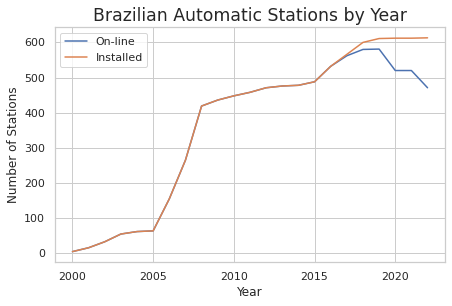

In [3]:
stations_sum = pd.DataFrame(
    data = {
        'Activated stations': stations.groupby(['year_first']).size(),
        'Deactivated stations': stations[~stations['station_on']].groupby('year_last').size()
    },
    index=stations.groupby(['year_first']).size().index
)

years = np.arange(stations['year_first'].min(), stations['year_last'].max()+1)

stations_sum = stations_sum.reindex(years, fill_value=0)

stations_sum = stations_sum.fillna(0).reset_index()

stations_sum[['Activated stations', 'Deactivated stations']] = stations_sum[['Activated stations', 'Deactivated stations']].astype('int16')

stations_sum['On-line stations'] = (stations_sum['Activated stations'] - stations_sum['Deactivated stations']).cumsum()

stations_sum['Installed stations'] = (stations_sum['Activated stations']).cumsum()

stations_sum.rename(columns={'year_first':'Year'}, inplace=True)

sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(7, 7 * 0.618))

g = sns.lineplot(x="Year", y="On-line stations", data=stations_sum, ax=ax, label='On-line');
g = sns.lineplot(x="Year", y="Installed stations", data=stations_sum, ax=ax, label='Installed');
g.set_title('Brazilian Automatic Stations by Year', fontsize='x-large');
g.set_ylabel('Number of Stations');

The diference between the two lines is considered deactivated as well. The first year with station shut down is 2016.

# 3. Weather Change at Brazilian Cities

As I said before, I am seeking to create a notebook that compares climate change between two cities in Brazil that has an automatic weather station. In the first notebook, I collected the data from the INMET website and I did one first summarize step. The dataset presets the columns:

* ESTACAO / STATION
* DATA (YYYY-MM-DD) / DATE (YYYY-MM-DD)
* HORA (UTC) / TIME (UTC)
* PRECIPITACAO TOTAL HORARIO (mm) / TOTAL HOURLY RAIN (mm)
* PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  / ATMOSPHERIC PRESSURE AT STATION LEVEL, TIME (mB)
* PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB) / MAX. ATMOSPHERIC PRESSURE IN THE PREVIOUS TIME. (AUT) (mB)
* PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB) / ATMOSPHERIC PRESSURE MIN. IN THE EARLY TIME. (AUT) (mB)
* RADIACAO GLOBAL (W/m2) / GLOBAL RADIATION (W/m2)
* TEMPERATURA DO AR - BULBO SECO, HORARIA (C) / AIR TEMPERATURE - DRY BULB, TIME (C)
* TEMPERATURA DO PONTO DE ORVALHO (C) / DEW POINT TEMPERATURE (C)
* TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C) / MAXIMUM TEMPERATURE IN THE PREVIOUS TIME. (AUT) (C)
* TEMPERATURA MINIMA NA HORA ANT. (AUT) (C) / MINIMUM TEMPERATURE IN THE PREVIOUS TIME. (AUT) (C)
* TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C) / MAX DEW TEMPERATURE. IN THE EARLY TIME. (AUT) (C)
* TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C) / DEW TEMPERATURE MIN. IN THE EARLY TIME. (AUT) (C)
* UMIDADE REL. MAX. NA HORA ANT. (AUT) (%) / REL HUMIDITY MAX. IN THE EARLY TIME. (AUT) (%)
* UMIDADE REL. MIN. NA HORA ANT. (AUT) (%) / REL HUMIDITY MIN IN THE EARLY TIME. (AUT) (%)
* UMIDADE RELATIVA DO AR, HORARIA (%) / RELATIVE AIR HUMIDITY, HOURS (%)
* VENTO, DIRECAO HORARIA (gr) / WIND, TIME DIRECTION (gr)
* VENTO, RAJADA MAXIMA (m/s) / WIND, MAXIMUM GUNS (m/s)
* VENTO, VELOCIDADE HORARIA (m/s) / WIND, HOUR SPEED (m/s)

As we are looking at climate change, we need to focus on extremes as average measures as well. On this way, we selected the following columns: 

* PRECIPITACAO TOTAL HORARIO (mm) / TOTAL HOURLY RAIN (mm) = MAX RAIN HOURLY
* RADIACAO GLOBAL (W/m2) / GLOBAL RADIATION (W/m2) = MAX RADIATION
* TEMPERATURA DO AR - BULBO SECO, HORARIA (C) / AIR TEMPERATURE - DRY BULB, TIME (C) = AVERAGE TEMPERATURE
* TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C) / MAXIMUM TEMPERATURE IN THE PREVIOUS TIME. (AUT) (C) = MAX TEMPERATURE(OBS.: We will create a new variable to measure the delta tempererature in a day)
* TEMPERATURA MINIMA NA HORA ANT. (AUT) (C) / MINIMUM TEMPERATURE IN THE PREVIOUS TIME. (AUT) (C) = MIN TEMPERATURE (OBS.: We will create a new variable to measure the delta tempererature in a day)
* UMIDADE REL. MAX. NA HORA ANT. (AUT) (%) / REL HUMIDITY MAX. IN THE EARLY TIME. (AUT) (%) = MAX HUMIDITY (OBS.: We will create a new variable to measure the delta humidity in a day)
* UMIDADE REL. MIN. NA HORA ANT. (AUT) (%) / REL HUMIDITY MIN IN THE EARLY TIME. (AUT) (%) = MIN HUMIDITY (OBS.: We will create a new variable to measure the delta humidity in a day)
* UMIDADE RELATIVA DO AR, HORARIA (%) / RELATIVE AIR HUMIDITY, HOURS (%) = AVERAGE HUMITY
* VENTO, RAJADA MAXIMA (m/s) / WIND, MAXIMUM GUNS (m/s) = MAX WIND SPEED
* VENTO, VELOCIDADE HORARIA (m/s) / WIND, HOUR SPEED (m/s) = AVERAGE WIND SPEED

On the first part, we pick raw data and and grouped by day. 

Here I get an important point, we will only compare cities on the period that automatic stations are working as well in both cities. As default our notebook will compare **Juiz de Fora, Minas Gerais**, my actual home city, with **Divinopolis, Minas Gerais**, my birth city. Other important thing is, we will only compare the variable on the period that the two stations present data. On other words, we will look to first and last record of each station and analyze our observations.

OBS.: cities selections are hard code now. Hope I can change this on future!

### 3.1. Graphical Analysis

Given the cities, let's see how far they are and how long our analysis will be!

In [4]:
id_station_1 = 'A518'

id_station_2 = 'A564'

stations_city = stations[stations['id_station'].isin([id_station_1, id_station_2])].reset_index(drop=True)

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return int(round(c * r, 0))

lon1, lat1 = stations_city.loc[0][['lon', 'lat']]

lon2, lat2 = stations_city.loc[1][['lon', 'lat']]

dist_cities = haversine(lon1, lat1, lon2, lat2)

plot_title = stations_city.loc[0]['city_station'] + ' and ' + stations_city.loc[1]['city_station'] + \
    ' are ' + str(dist_cities) + 'km apart...'

# Stations geoplot
# Hoverdata
hover_map = {
    'state':True,
    'id_station':True,
    'lon':':.4f',
    'lat':':.4f',
}

fig = px.scatter_geo(stations_city,
                    lat='lat',
                    lon='lon',
                    symbol='station_on',
                    color='year_last_str',
                    hover_name='city_station',
                    hover_data=hover_map,
                    # fitbounds="locations",
                    title=plot_title,
                    labels={
                        'year_last_str':'Last Record Year',
                        'station_on':'Station Online',
                        'state':'State',
                        'id_station':'ID',
                        'lat':'Lat',
                        'lon':'Lon'
                    },
                    scope='south america',
                    width=750,
                    )

fig.show()

In [5]:
# Importing weather information summarize DataFrame
weather = pd.read_csv(
    '../input/brazil-weather-information-by-inmet/weather_sum_all/weather_sum_all.csv',
    parse_dates=['DATA (YYYY-MM-DD)']
)

# Renaming columns
weather.columns.values[0] = 'id_station'
weather.columns.values[1] = 'date'

# Filtering the weather information by cities chosen
weather_cities = weather.merge(stations_city, on='id_station')

# Finding and preseting the period of analysis
period = str(weather_cities['record_first'].max().strftime('%Y-%m-%d')) + ' to ' + str(weather_cities['record_last'].max().strftime('%Y-%m-%d'))

display(Markdown('Our analysis will cover the **' + period + '**. Lets see some plots!'))

Our analysis will cover the **2017-10-26 to 2022-04-30**. Lets see some plots!

In [6]:
# Filtering the weather information by records at sametime
weather_cities = weather_cities[
    (weather_cities['date'] >= weather_cities['record_first'].max()) & (weather_cities['date'] <= weather_cities['record_last'].max())
].reset_index(drop=True)

cols_sum = list(weather.columns.values[2:])

# Extracting year and month
weather_cities['record_year'] = pd.DatetimeIndex(weather_cities['date']).year
weather_cities['record_month'] = pd.DatetimeIndex(weather_cities['date']).month
weather_cities['record_day'] = pd.DatetimeIndex(weather_cities['date']).day

weather_cities_day = weather_cities[~((weather_cities['record_month'] == 2) & (weather_cities['record_day'] == 29))]

day_ref = weather_cities_day['date'].min().replace(year=weather_cities_day['record_year'].min()+1)

weather_cities_day_ref = weather_cities_day[weather_cities['date'] < day_ref]

weather_cities_day_rec = weather_cities_day[~(weather_cities['date'] < day_ref)]

cols_days = ['id_station', 'city_station', 'record_year', 'record_month', 'record_day']

for col in weather_cities_day_rec.columns:
    if col[-3] == 'm':
        cols_days.append(col)

_cols_drop = [col for col in weather_cities_day_rec.columns if col not in cols_days]

weather_cities_day_ref.drop(_cols_drop, inplace=True, axis=1, errors='ignore')

weather_cities_day_rec.drop(_cols_drop, inplace=True, axis=1, errors='ignore')

# Defining the coluns to melt function
cols_day = [col for col in weather_cities_day_ref.columns if col[-3] == 'm']

cols_id = [col for col in weather_cities_day_ref.columns if col not in cols_day]

weather_cities_day_ref_melt = weather_cities_day_ref.melt(
    id_vars=cols_id,
    var_name='weather_var',
    value_name='weather_value'
)

weather_cities_day_ref_melt['ref_day'] = weather_cities_day_ref_melt.groupby(['id_station', 'weather_var']).cumcount().add(1) % 365 

weather_cities_day_ref_melt.loc[weather_cities_day_ref_melt['ref_day'] == 0, 'ref_day'] = 365

weather_cities_day_ref_melt['ref_year'] = weather_cities_day_ref_melt.groupby(['id_station', 'weather_var']).cumcount().add(1) // 365

weather_cities_day_rec_melt = weather_cities_day_rec.melt(
    id_vars=cols_id,
    var_name='weather_var',
    value_name='weather_value'
)

weather_cities_day_compare = weather_cities_day_ref_melt.merge(
    weather_cities_day_rec_melt,
    on=['id_station', 'city_station', 'record_month', 'record_day', 'weather_var'],
    suffixes=('_ref', '_rec')
)

weather_cities_day_compare.sort_values(['id_station', 'city_station', 'weather_var', 'ref_day'], inplace=True) # introduzido

weather_cities_day_compare = weather_cities_day_compare.fillna(method="ffill") # introduzido

rows_max = [row for row in weather_cities_day_compare['weather_var'].unique() if row[-3:] == 'max']

rows_max_select = weather_cities_day_compare['weather_var'].isin(rows_max)

weather_cities_day_compare['var_gui'] = True

# Analyzing each row considering if is a max or min variable
weather_cities_day_compare.loc[rows_max_select, 'var_gui'] = weather_cities_day_compare.loc[rows_max_select,'weather_value_ref'] < weather_cities_day_compare.loc[rows_max_select,'weather_value_rec']

weather_cities_day_compare.loc[~rows_max_select, 'var_gui'] = weather_cities_day_compare.loc[~rows_max_select,'weather_value_ref'] > weather_cities_day_compare.loc[~rows_max_select,'weather_value_rec']

In [7]:
# Slicing and listing data frame to plot
def weather_slice(df=weather_cities_day_compare):
    return [
        df[df['city_station'] == df['city_station'].unique()[0]],
        df[df['city_station'] == df['city_station'].unique()[1]]
    ]

weather_plot_day = weather_slice()

# Dictionaries to help label the plots
cols_name = {
    'rain_max':  'Maximun Hour Rain',
    'rad_max':  'Maximun Radiation',
    'temp_avg':  'Average Temperature',
    'temp_max':  'Maximun Temperature',
    'temp_min':  'Minimun Temperature',
    'hum_max':  'Maximun Humidit',
    'hum_min':  'Minimun Humidit',
    'wind_max':  'Maximun Wind Speed',
    'wind_avg':  'Average Wind Speed',
    'temp_delta': 'Maximun Delta Temperature',
    'hum_delta': 'Maximun Delta Humity'
}

cols_name_y = {
    'rain_max':  'Hour Rain (mm)',
    'rad_max':  'Radiation (W/m2)',
    'temp_avg':  'Average Temperature (oC)',
    'temp_max':  'Maximun Temperature (oC)',
    'temp_min':  'Minimun Temperature (oC)',
    'hum_max':  'Maximun Humidit (%)',
    'hum_min':  'Minimun Humidit (%)',
    'hum_avg':  'Average Humidit (%)',
    'wind_max':  'Wind Speed (m/s)',
    'wind_avg':  'Wind Speed (m/s)',
    'temp_delta': 'Maximun Delta Temperature (oC)',
    'hum_delta': 'Maximun Delta Humity (%)'
}

dict_month = {
    1: 'Jan',
    2: 'Fev',
    3: 'Mar',
    4: 'Abr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Ago',
    9: 'Set',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

# Defining the xticks
xticksmarks = [row + 1 for row in weather_cities_day_ref.index if (weather_cities_day_ref.loc[row, 'record_day'] == 1) & (row < 366)]

xtickslabels = [weather_cities_day_ref.loc[row, 'record_month'] for row in weather_cities_day_ref.index if (weather_cities_day_ref.loc[row, 'record_day'] == 1) & (row < 366)]

xtickslabels = [dict_month[x] for x in xtickslabels]

# Counting the number of 
def hist_plot_day(weather_var='temp_max',city=0):
    
    df = weather_plot_day[city][(weather_plot_day[city]['weather_var'] == weather_var)]
    
    df = df.groupby(['ref_day'], as_index=False)['var_gui'].sum()
    
    g = sns.lineplot(
        x="ref_day",
        y='var_gui',
        ci=None,
        color='orange',
        data= df, # weather_plot_day[city][(weather_plot_day[city]['weather_var'] == weather_var) & (weather_plot_day[city]['var_gui'])],
        ax=ax[0, city]
    )
    
    if weather_var[-3:] == 'max':
        ylabel = 'Years Higher'
    else:
        ylabel = 'Years Smaller'
    
    g.set_xlabel('')
    
    g.set_xticks(xticksmarks, labels=xtickslabels)
    
    g.set_ylabel(ylabel)
    
    g.set_title(weather_plot_day[city]['city_station'].unique()[0], fontsize='x-large')
    
    return g

# Defining the xlabel
start_period = weather_cities['record_first'].max()
end_period = start_period + pd.offsets.DateOffset(days=364)

# Line plot considering the weather_var by day on the fist year
def line_plot_day(weather_var='temp_max',city=0):
    
    g = sns.lineplot(
        x="ref_day",
        y='weather_value_ref',
        ci=None,
        #lw=1,
        data=weather_plot_day[city][(weather_plot_day[city]['weather_var'] == weather_var) & (weather_plot_day[city]['ref_year'] == 0)],
        ax=ax[1, city]
    )
    
    g.set_xticks(xticksmarks, labels=xtickslabels)
    
    xlabel = 'Line = Values on ' + str(start_period.strftime('%Y-%m-%d')) + ' to ' + str(end_period.strftime('%Y-%m-%d')) + '| Points = Following Years ' + ('Higher' if weather_var[-3:] == 'max' else 'Smaller')
        
    g.set_xlabel(xlabel)
    
    g.set_ylabel(cols_name_y[weather_var])
    
    g.set_ylim(bottom=0)
    
    return g

# Scatter plot to show day that is higher or smaller than the day reference
def scatter_plot_day(weather_var='temp_max',city=0):
    
    g = sns.scatterplot(
        x="ref_day",
        y='weather_value_rec',
        color='orange',
        s=9,
        data=weather_plot_day[city][(weather_plot_day[city]['weather_var'] == weather_var) & (weather_plot_day[city]['var_gui'])],
        ax=ax[1, city]
    )
    
    g.set_xticks(xticksmarks, labels=xtickslabels)
    
    xlabel = 'Line = Values on ' + str(start_period.strftime('%Y-%m-%d')) + ' to ' + str(end_period.strftime('%Y-%m-%d')) + ' | Points = Following Years ' + ('Higher' if weather_var[-3:] == 'max' else 'Smaller')
        
    g.set_xlabel(xlabel)
    
    g.set_ylabel(cols_name_y[weather_var])
    
    g.set_ylim(bottom=0)
    
    return g

#### 3.1.1. Maximun Humidit

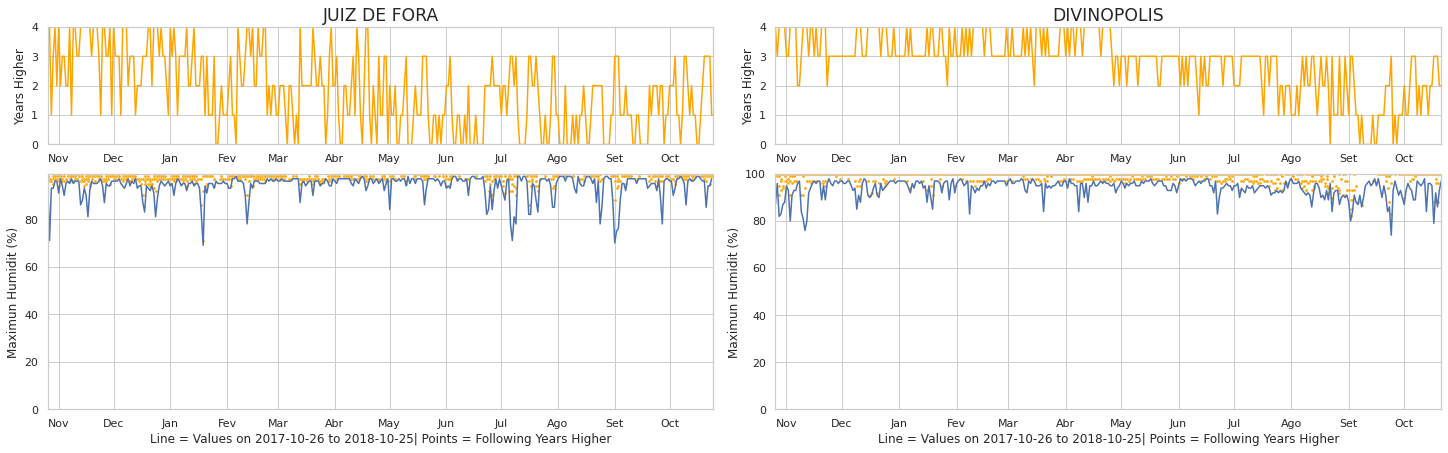

#### 3.1.2. Minimun Humidit

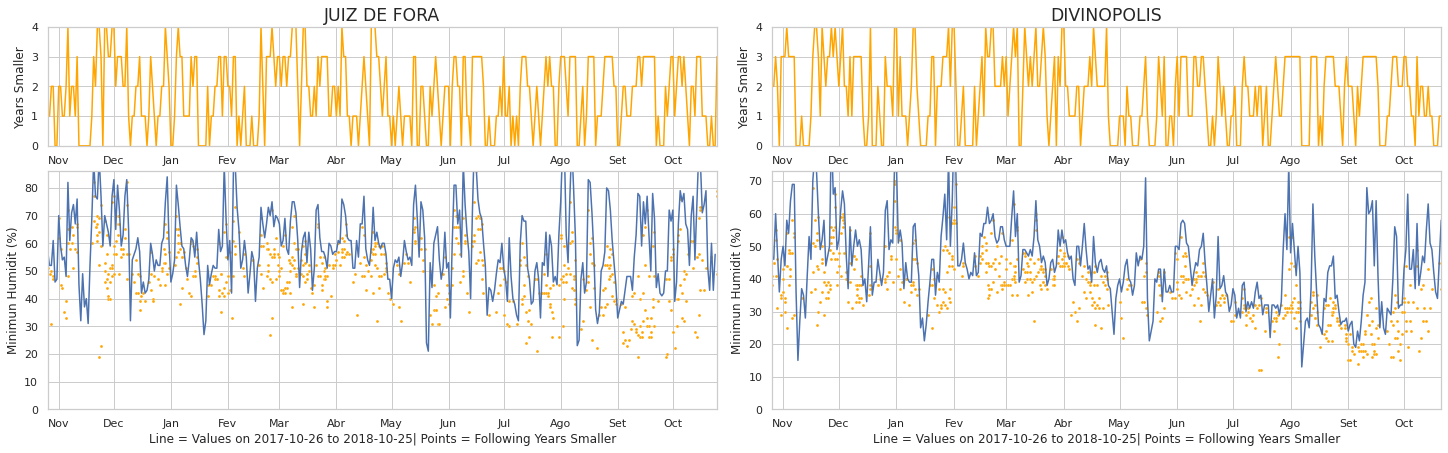

#### 3.1.3. Maximun Radiation

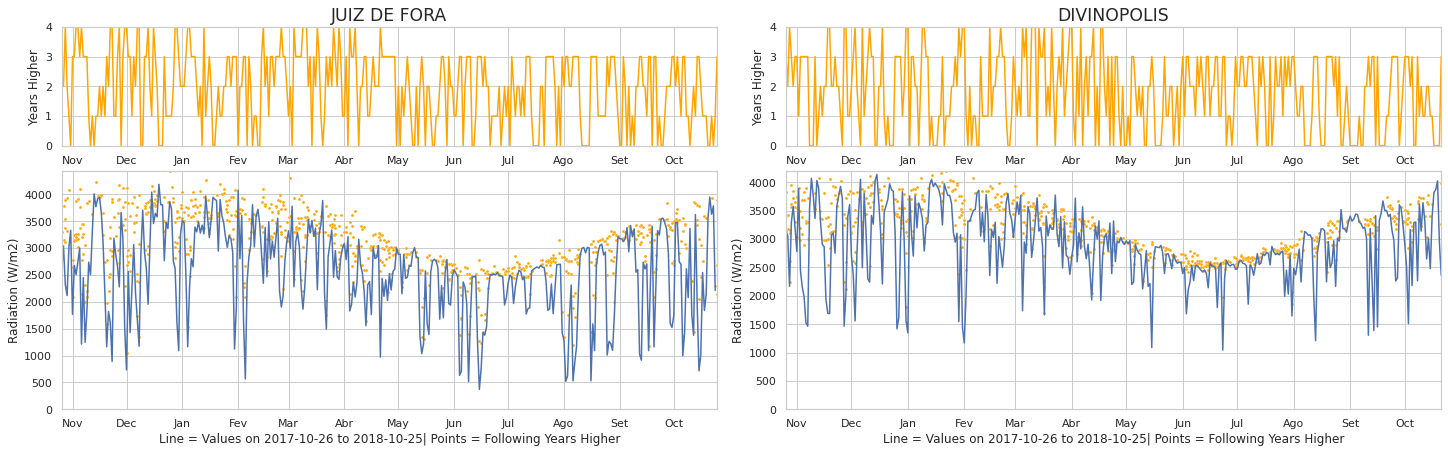

#### 3.1.4. Maximun Hour Rain

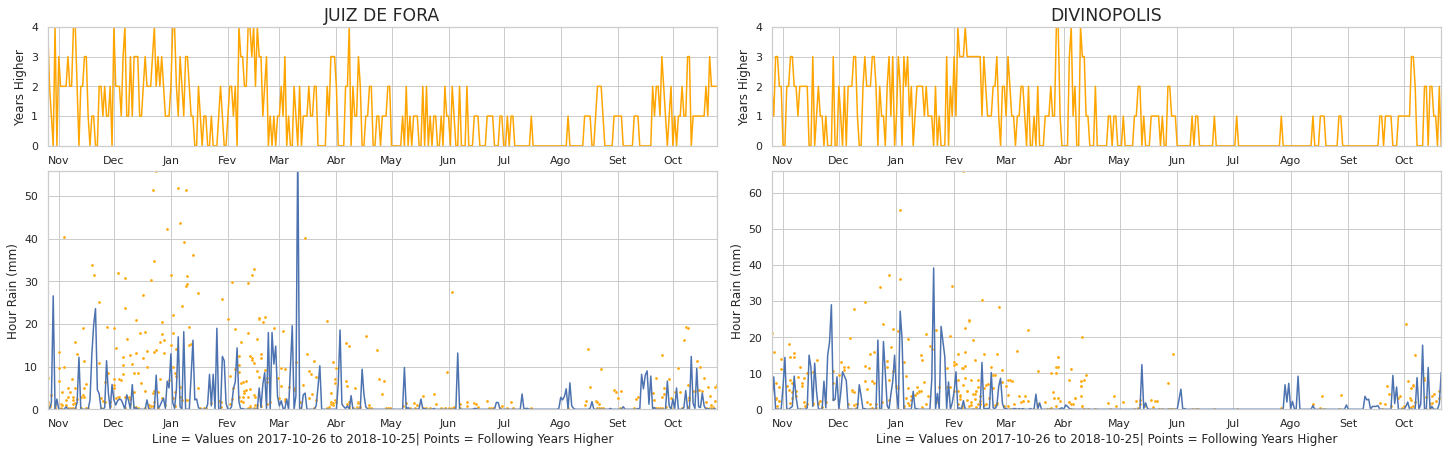

#### 3.1.5. Maximun Temperature

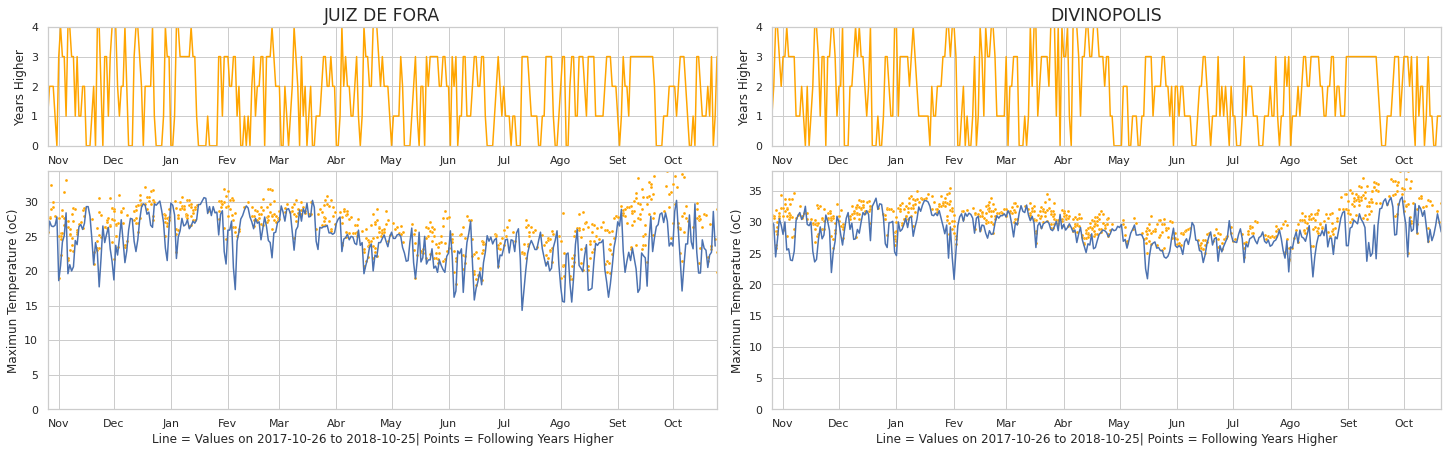

#### 3.1.6. Minimun Temperature

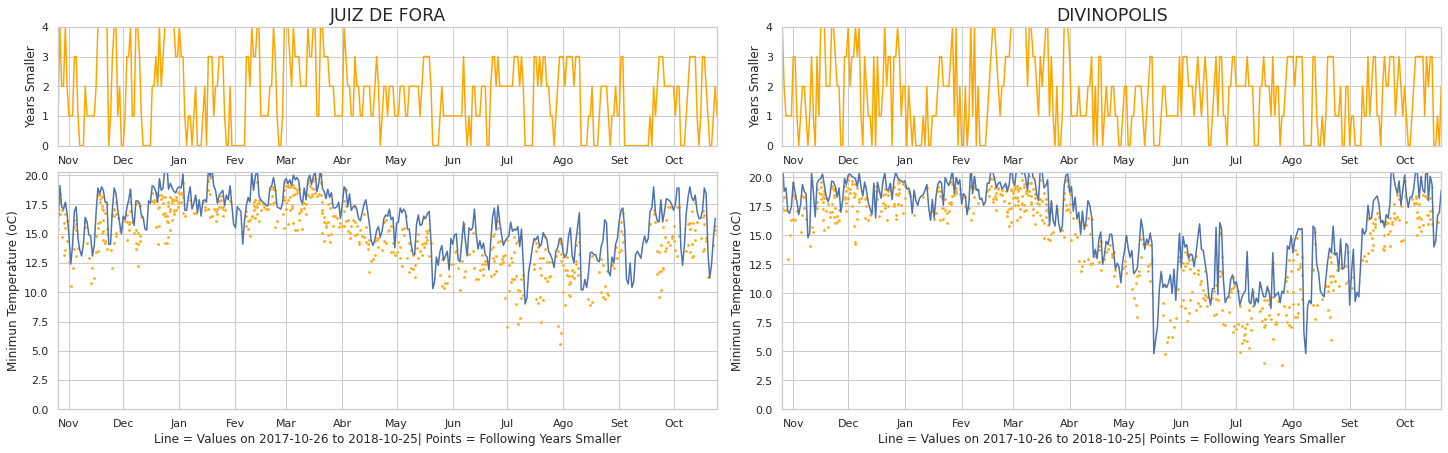

#### 3.1.7. Maximun Wind Speed

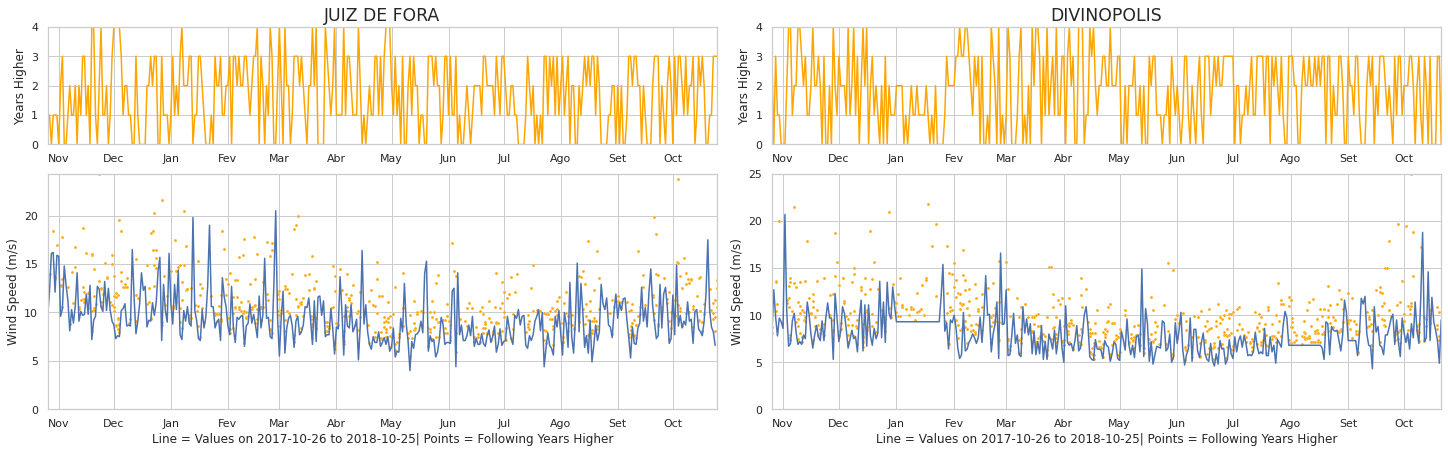

In [8]:
i = 0

for var in weather_plot_day[0]['weather_var'].unique():
    i += 1
    
    display(Markdown('#### 3.1.' + str(i) + ". " + cols_name[var]))
    
    f, ax = plt.subplots(
        2, 2,
        figsize=(20, 10 * 0.618),
        gridspec_kw=dict(width_ratios=[3, 3], height_ratios=[1, 2]),
        constrained_layout=True)
    
    # f.suptitle(cols_name[var], fontsize='xx-large')
    
    ax[0,0].margins(0,0)
    ax[0,1].margins(0,0)
    ax[1,0].margins(0,0)
    ax[1,1].margins(0,0)

    g1 = hist_plot_day(weather_var=var)

    g2 = hist_plot_day(weather_var=var, city=1)

    g3 = scatter_plot_day(weather_var=var)
    
    g3 = line_plot_day(weather_var=var)

    g4 = scatter_plot_day(weather_var=var, city=1)
    
    g4 = line_plot_day(weather_var=var, city=1)
    
    plt.show()

Well, these are pretty plots! But, the process to reach some insights is a little bit on the user, plot by plot. Let's find another way to analyze the climate change between the cities.

### 3.2. First 12-month Standard Comparation

Climate change is real. There is a lot of studies done about it and we do not want to prove it or measure how strong it is. Well, but we can easily see if our two cities represent the same change on the study period. To reach this, we will define the reference with the 12 first month and them compare month by month with the rest of period. Here, we may read compare as:

$$\frac {month\_act}{month\_ref}$$

Our hypotheses here is that, given a weather measure, it varie different between the two cities. If the p-value is small, or hypotheses for that measure is true. Otherwise, if p-value is high, our hypothesis is false. After this we will have the measures that change differently and the ones that change equally or almost equally. Let's see what our data say and our first step is: data quality!

In [9]:
weather_qual = weather_cities.groupby(['city_station', 'record_year', 'record_month'], as_index=False)[cols_sum].agg(lambda x: x.isna().mean())

weather_qual = weather_qual.groupby(['city_station'], as_index=False)[cols_sum].max()

weather_qual_melt = weather_qual.melt(
    id_vars='city_station',
    var_name='weather_var',
    value_name='var_perc_bad'
)

weather_qual_melt.sort_values(['var_perc_bad', 'city_station'], ascending=False, inplace=True)

display(Markdown('**Table: Maximun Proportion of NA Values per Column and City**'))

HTML(
    weather_qual.to_html(
        escape=False,
        index=False,
        formatters={
            'rain_max': '{:,.2%}'.format,
            'rad_max': '{:,.2%}'.format,
            'temp_avg': '{:,.2%}'.format,
            'temp_max': '{:,.2%}'.format,
            'temp_min': '{:,.2%}'.format,
            'hum_max': '{:,.2%}'.format,
            'hum_min': '{:,.2%}'.format,
            'wind_max': '{:,.2%}'.format,
            'wind_avg': '{:,.2%}'.format,
        }
    )     
)


**Table: Maximun Proportion of NA Values per Column and City**

city_station,rain_max,rad_max,temp_avg,temp_max,temp_min,hum_max,hum_min,wind_max,wind_avg
DIVINOPOLIS,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,74.19%,74.19%
JUIZ DE FORA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [10]:
# Creating new variables
if ('temp_max' in list(weather_cities.columns)) and ('temp_min' in list(weather_cities.columns)):
    weather_cities['temp_delta'] = weather_cities['temp_max'] - weather_cities['temp_min']
    cols_sum.append('temp_delta')
else:
    print('temp_max or temp_min were dropped, so temp_delta was not created.')
    
if ('hum_max' in list(weather_cities.columns)) and ('hum_min' in list(weather_cities.columns)):
    weather_cities['hum_delta'] = weather_cities['hum_max'] - weather_cities['hum_min']
    cols_sum.append('hum_delta')
else:
    print('temp_max or temp_min were dropped, so temp_delta was not created.')
    
# Summaring cities data
# Droping non necessary columns
_cols_drop = [
    'region',
    'state',
    'lat',
    'lon',
    'lvl',
    'record_first',
    'record_last',
    'year_first',
    'year_last',
    'station_on',
]

weather_cities.drop(columns=_cols_drop, inplace=True, errors='ignore')

# Creating the agg dictionary
cols_agg = {}
for col in cols_sum:
    if col[-3] == 'm':
        cols_agg[col] = col[-3:]
    else:
        cols_agg[col] = 'mean'
        
weather_cities_sum = weather_cities.groupby(['id_station', 'city_station', 'record_year', 'record_month'], as_index=False).agg(cols_agg)

# Creating a fake indexing as reference
month_station_1 = sum(weather_cities_sum['id_station'] == id_station_1)
month_station_2 = sum(weather_cities_sum['id_station'] == id_station_2)

if month_station_1 == month_station_2:
     print("The cities show the same number of months.")
else:
    print("The cities does not show the same number of months.") # Next version: stop kernel
    
weather_cities_sum['month_agg'] = weather_cities_sum.groupby('id_station').cumcount().add(1)

weather_cities_sum['month_ref'] = weather_cities_sum['month_agg'] % 12

weather_cities_sum.loc[weather_cities_sum['month_ref'] == 0, 'month_ref'] = 12

cols_id = [col for col in weather_cities_sum.columns if col not in cols_sum]

weather_cities_sum_melt = weather_cities_sum.melt(
    id_vars=cols_id,
    var_name='weather_var',
    value_name='weather_val'
)

weather_cities_ref = weather_cities_sum_melt.groupby(['id_station', 'weather_var']).head(12)

# Important: insert a protection for one ref equal 0
if ((weather_cities_ref['weather_val'] == 0).sum() == 0):
    print('Nothing to worrie zero values!')
else:
    print('Well, it is important to see reference values equal 0!')
    
# Important: insert a protection for a month only with NA
if (weather_cities_ref['weather_val'].isna().sum() == 0):
    print('Nothing to worrie about NA values!')
else:
    print('Well, it is important to see NA reference values!')

The cities show the same number of months.
Well, it is important to see reference values equal 0!
Nothing to worrie about NA values!


In [11]:
weather_cities_ref = weather_cities_ref.filter(['id_station', 'month_ref', 'weather_var', 'weather_val'])

weather_cities_compare = weather_cities_sum_melt.merge(
    weather_cities_ref, 
    on=['id_station', 'month_ref', 'weather_var'],
    suffixes=('_act', '_ref')
)

weather_cities_compare['weather_val_kpi'] = weather_cities_compare['weather_val_act'] / weather_cities_compare['weather_val_ref']

weather_cities_compare['weather_val_kpi'].replace([np.inf, -np.inf], 2, inplace=True)
weather_cities_compare['weather_val_kpi'].replace(np.NaN, 1, inplace=True)

weather_cities_compare['weather_val_abs'] = abs(1 - weather_cities_compare['weather_val_kpi'])

weather_cities_compare.sort_values(['city_station', 'record_year', 'record_month'], inplace=True)

In [12]:
# Slicing data into lists
weather_plot_month = weather_slice(weather_cities_compare)

# Creating DataFrame to Seaborn heatmap
def df_to_heat(df=weather_plot_month,city=0, weather_var='rain_max'):
    
    df1 = df[city][(df[city]['weather_var'] == weather_var) & (df[city]['month_agg'] > 12)]
    
    df1 = df1[['record_year', 'record_month', 'weather_val_kpi']]
    
    df1 = pd.pivot(df1, index='record_year', columns='record_month', values='weather_val_kpi')
    
    df1.rename(dict_month, axis=1, inplace=True)
    
    return df1

# DataFrame do Seaborn KDE plot
def df_to_hist(df=weather_cities_compare, weather_var='rain_max'):
    df1 = df[(df['weather_var'] == weather_var) & (df['month_agg'] > 12)]
    
    df1 = df1[['city_station', 'record_year', 'record_month', 'weather_val_kpi']]
    
    return df1

# Creating a graycmap
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)

def weather_heat_map(city=0, weather_var='rain_max'):
    
    df = df_to_heat(city=city, weather_var=weather_var)
    
    g = sns.heatmap(
        df,
        annot=True,
        fmt=".3",
        linewidths=.5,
        ax=ax[1, city],
        center=1,
        cmap=grayscale_cmap('twilight_shifted'),
        cbar_kws=dict(label='Month value divide by month reference',drawedges=True));
    
    g.set_ylabel('Year');
    
    g.set_xlabel('Month');
    
    g.tick_params(axis='both', labelrotation=0);
    
    g.set_title(weather_plot_month[city]['city_station'].unique()[0]  + ' ' + str(cols_name[weather_var]) + ' Relation First Year',
                fontdict=dict(fontsize='x-large')
               );
    
    return g

def weather_kde(weather_var='rain_max'):
    
    df = df_to_hist(weather_var=weather_var)

    g = sns.kdeplot(
        data=df,
        x="weather_val_kpi",
        hue="city_station",
        ax=ax[0,0]
    );
    
    g = sns.rugplot(
        data=df,
        x='weather_val_kpi',
        hue='city_station',
        ax=ax[0,0]
    );
    
    g.set_xlabel(cols_name_y[weather_var]);
    
    g.set_title(cols_name[weather_var] + ' Density', fontsize='x-large');
    
    return g

# Defining the xticks
xticksmarks = [row + 1 for row in weather_cities_sum.index if (weather_cities_sum.loc[row, 'record_month'] == 1) & (row < 56)]

xtickslabels = [weather_cities_sum.loc[row, 'record_year'] for row in weather_cities_sum.index if (weather_cities_sum.loc[row, 'record_month'] == 1) & (row < 56)]

def weather_month(weather_var='rain_max'):
    g = sns.lineplot(
        x="month_agg",
        y=weather_var,
        data=weather_cities_sum,
        hue='city_station',
        ax=ax[0,1]);

    g.set_title(cols_name[weather_var] + ' Historic Monthly', fontsize='x-large');

    g.set_ylabel(cols_name_y[weather_var]);
    
    g.set_xlabel('Year')
    
    g.legend(title='');
    
    g.set_xticks(xticksmarks, labels=xtickslabels);
    
    g.set_ylim(bottom=0);
    
    return g

After some data wrangling, let's see the p-values for each measure. We will use here 0.05 as the threshold.

In [13]:
def p_weather(var='wind_avg'):
    p_weather = ttest_ind(
        weather_cities_compare[(
            (weather_cities_compare['city_station'] == weather_cities_compare['city_station'].unique()[0]) &
            ((weather_cities_compare['weather_var'] == var))
        )]['weather_val_kpi'],
        weather_cities_compare[(
            (weather_cities_compare['city_station'] != weather_cities_compare['city_station'].unique()[0]) &
            ((weather_cities_compare['weather_var'] == var))
        )]['weather_val_kpi']
    )[1]
    return p_weather

p_value_weather = [p_weather(col) for col in cols_sum]

df_p = pd.DataFrame(
    data={
        'Measure': cols_sum,
        'p.value': p_value_weather
    }
)

df_p['p.value'] = round(df_p['p.value'], 4)

df_p['Statistically Different'] = df_p['p.value'] < 0.05

df_p.replace(cols_name, inplace=True)

HTML(df_p.to_html(escape=False,index=False))

Measure,p.value,Statistically Different
Maximun Hour Rain,0.2169,False
Maximun Radiation,0.0544,False
Average Temperature,0.5269,False
Maximun Temperature,0.5817,False
Minimun Temperature,0.1375,False
Maximun Humidit,0.0000,True
Minimun Humidit,0.3709,False
Maximun Wind Speed,0.1657,False
Average Wind Speed,0.0000,True
Maximun Delta Temperature,0.1641,False


In [14]:
if df_p['Statistically Different'].sum() > len(df_p)/2:
    display(Markdown('More than 50% of measure are statistical different between the cities. On this way, we may say that weather change differently between cities.'))
elif df_p['Statistically Different'].sum() == 1:
    display(Markdown('All measures show statistical difference. On this way, we may say that weather change differently between cities.'))
elif df_p['Statistically Different'].sum() == 0:
    display(Markdown('All measures does not show any statistical difference. On this way, we may say that weather change equal or almost equal between cities.'))
else:
    display(Markdown('Less than 50% of measure are statistical different between the cities. On this way, we may say that weather change equal or almost equal between cities.'))

Less than 50% of measure are statistical different between the cities. On this way, we may say that weather change equal or almost equal between cities.

Now that we understand statisticaly the measure variances, let's see some plots!

OBS.: for the following heatmaps, darker means more changes on climate measures.

#### 3.2.1. Maximun Hour Rain

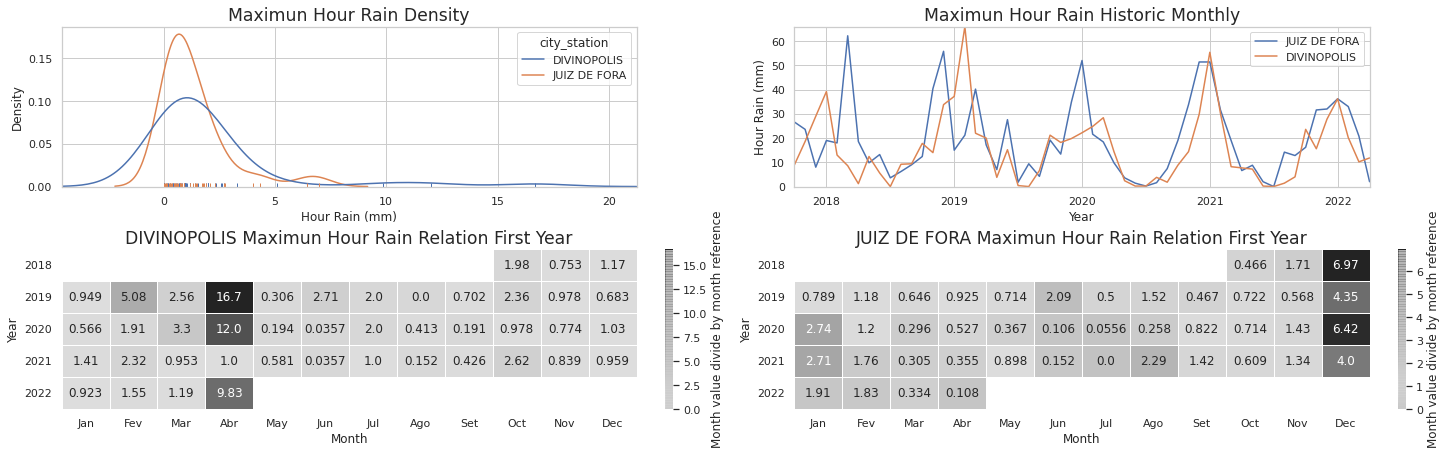

#### 3.2.2. Maximun Radiation

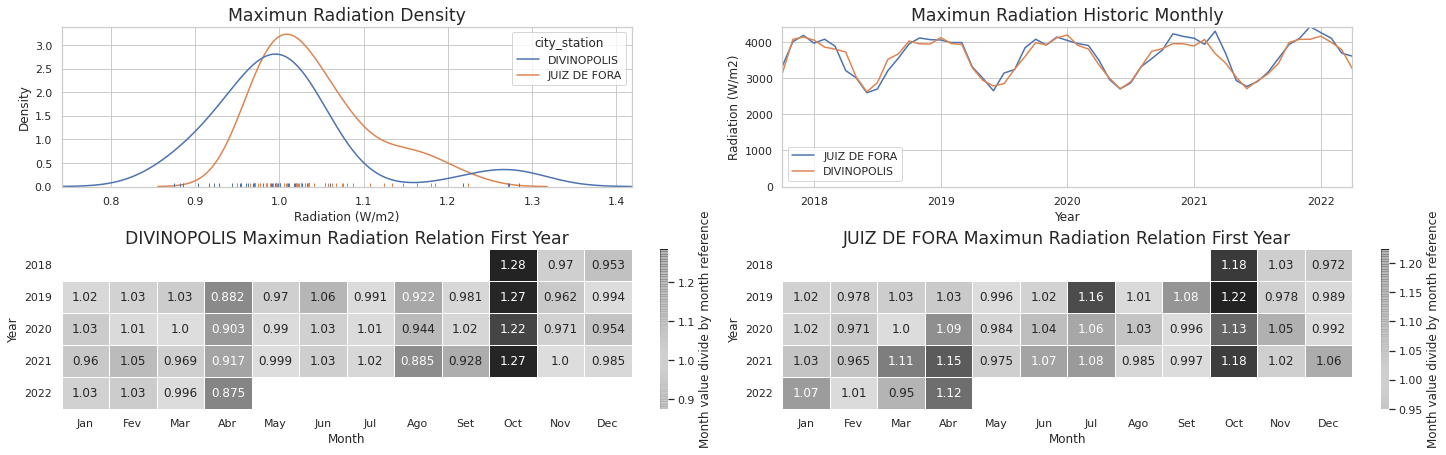

#### 3.2.3. Average Temperature

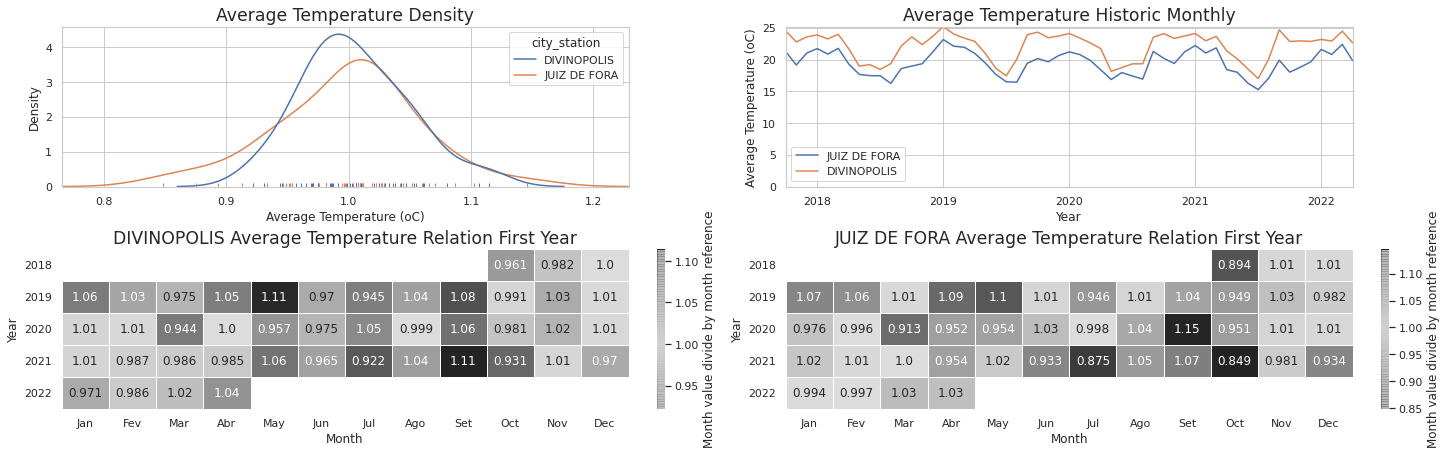

#### 3.2.4. Maximun Temperature

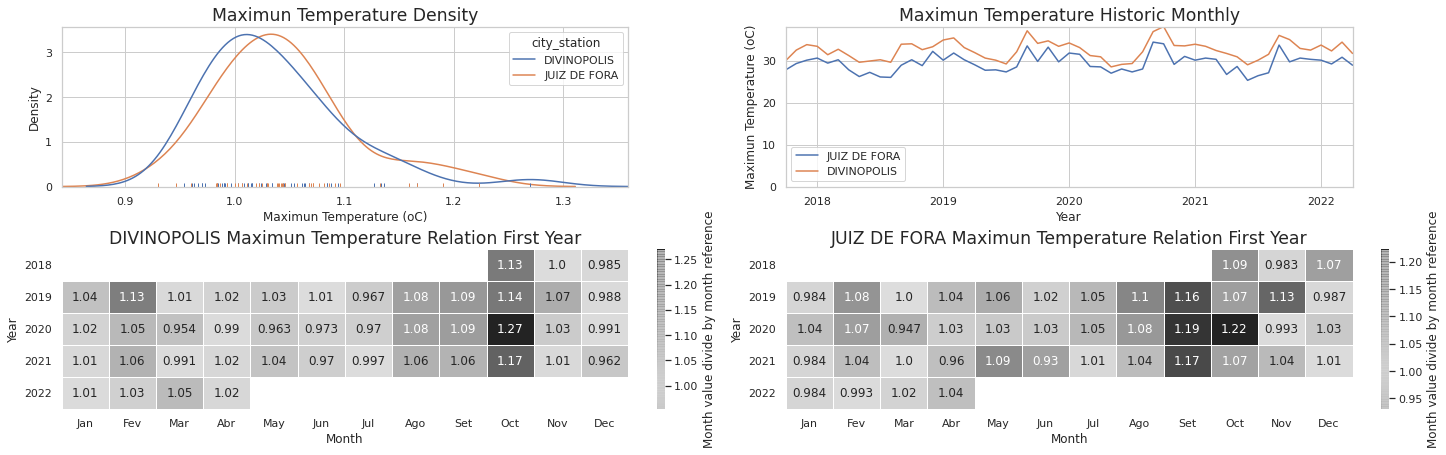

#### 3.2.5. Minimun Temperature

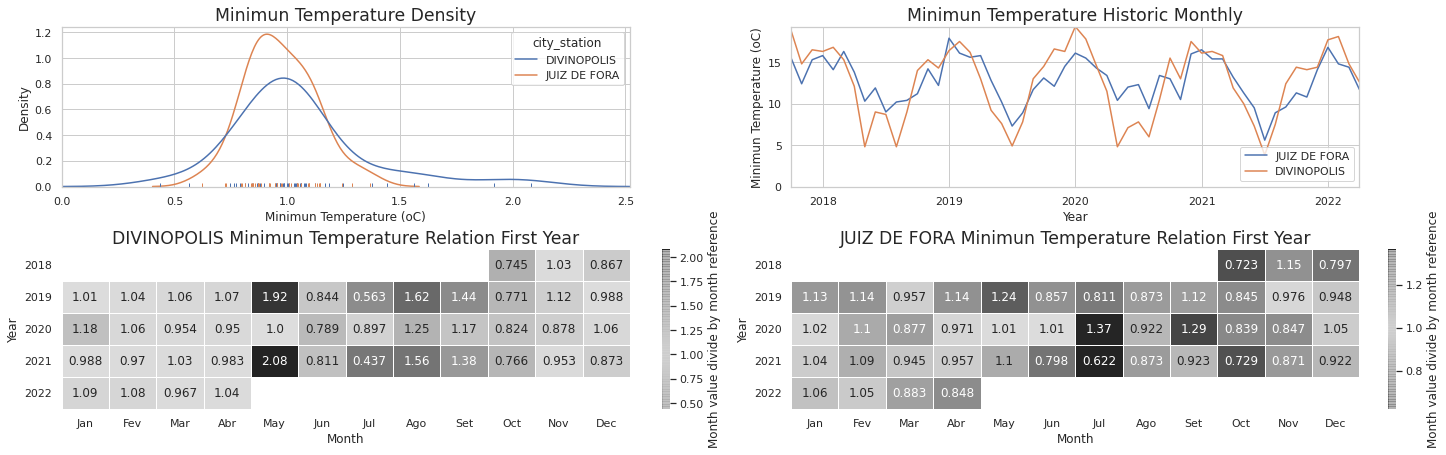

#### 3.2.6. Maximun Humidit

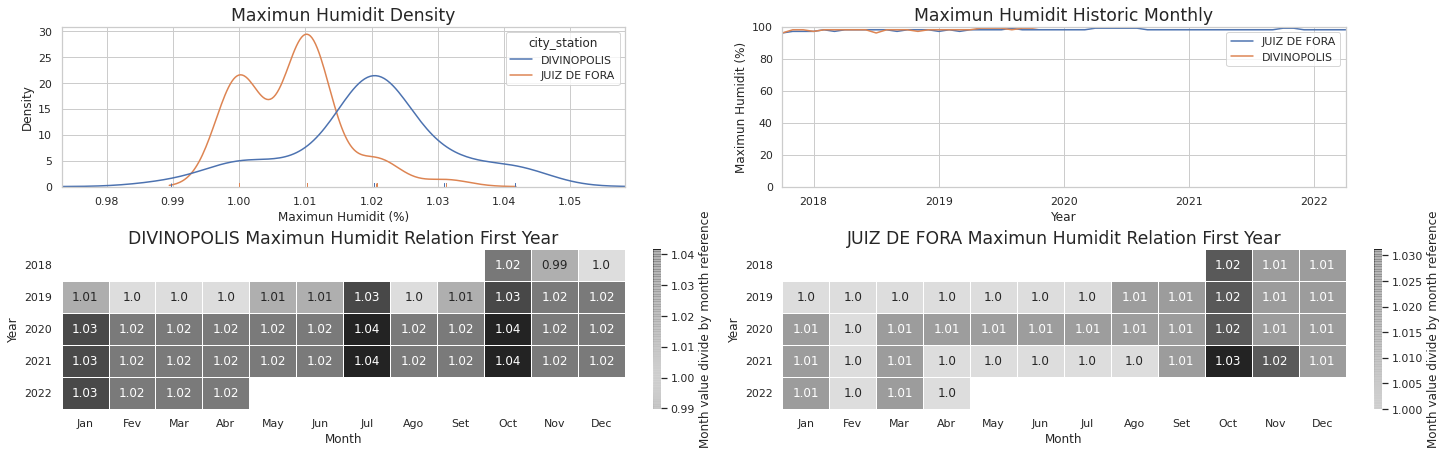

#### 3.2.7. Minimun Humidit

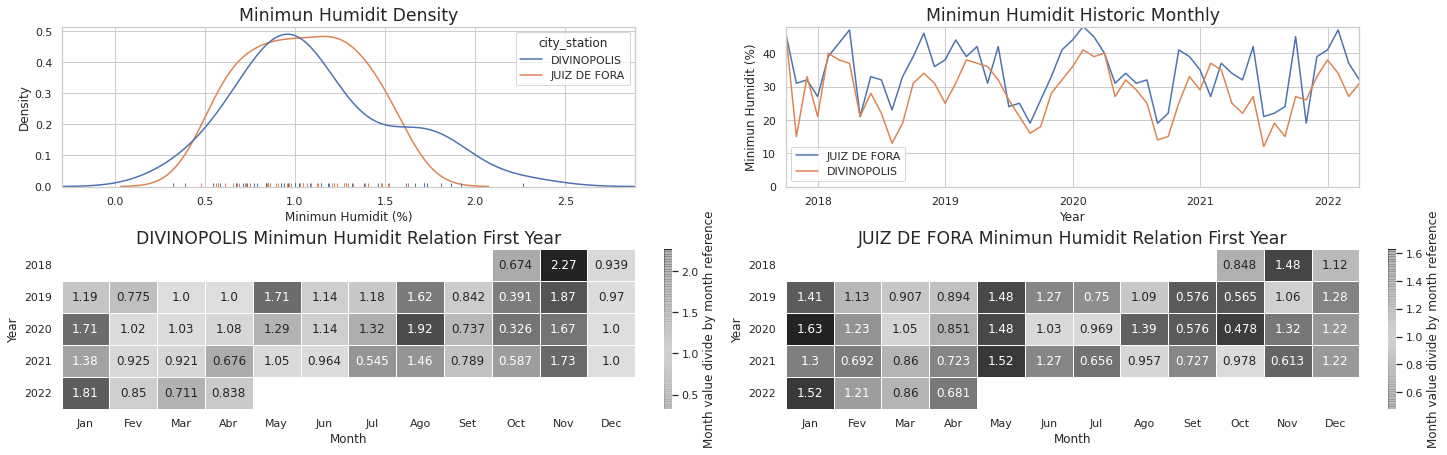

#### 3.2.8. Maximun Wind Speed

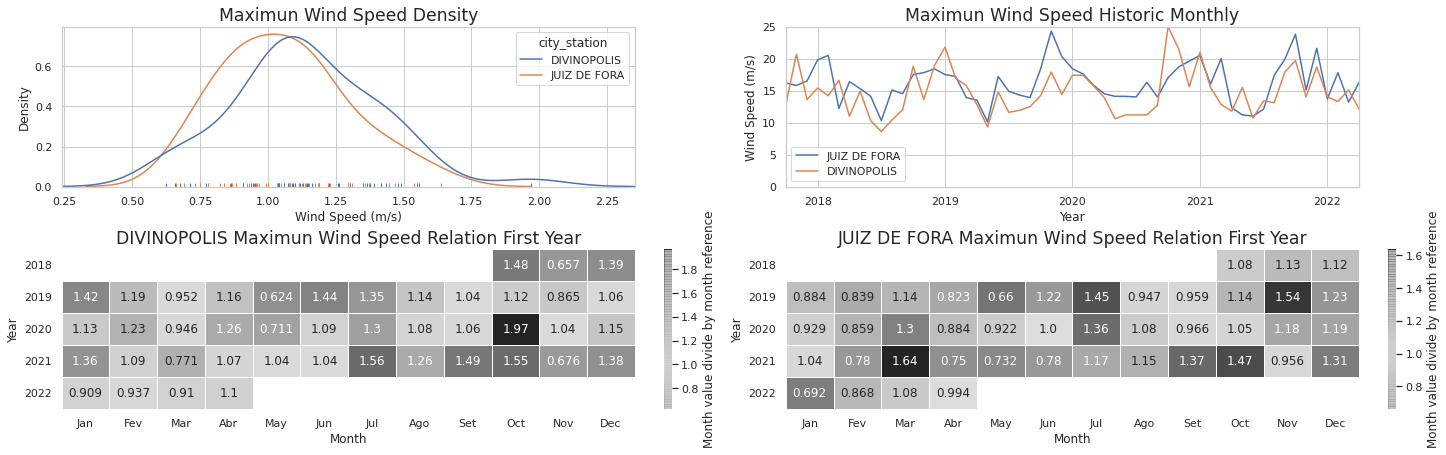

#### 3.2.9. Average Wind Speed

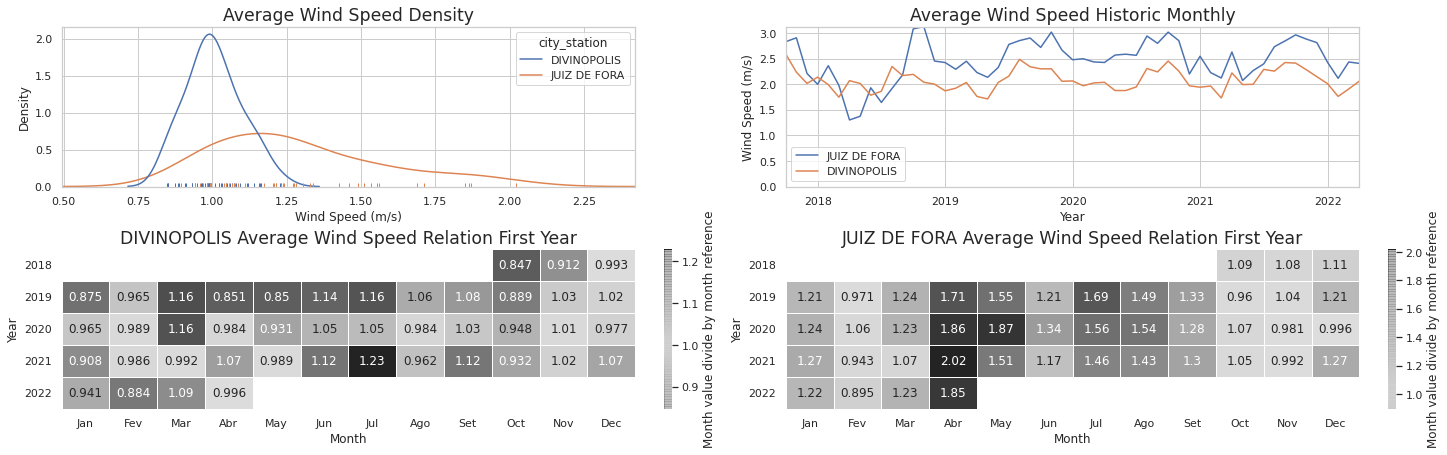

#### 3.2.10. Maximun Delta Temperature

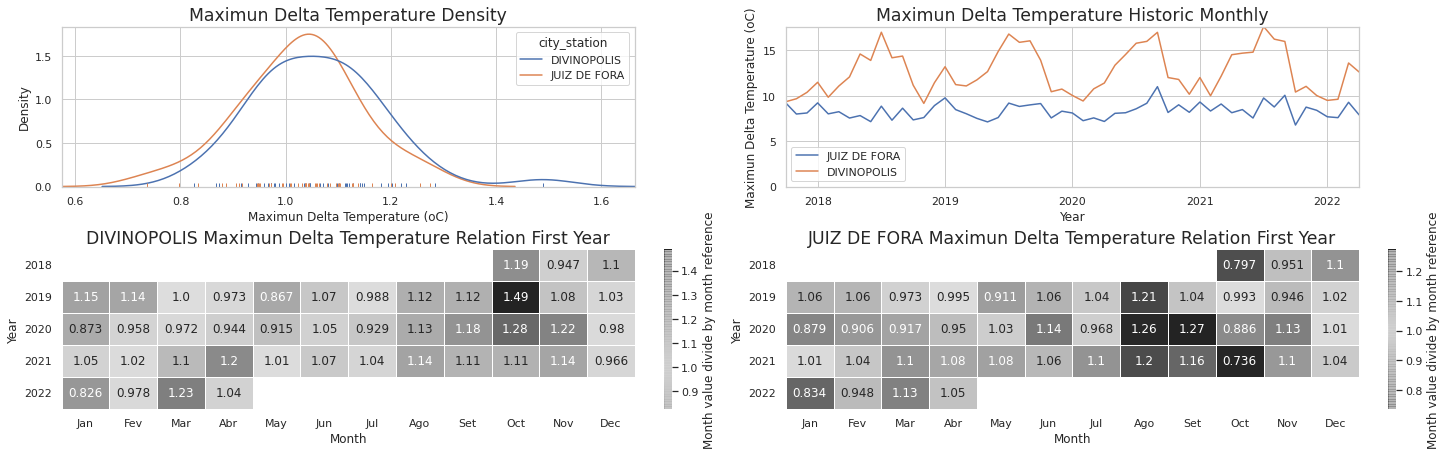

#### 3.2.11. Maximun Delta Humity

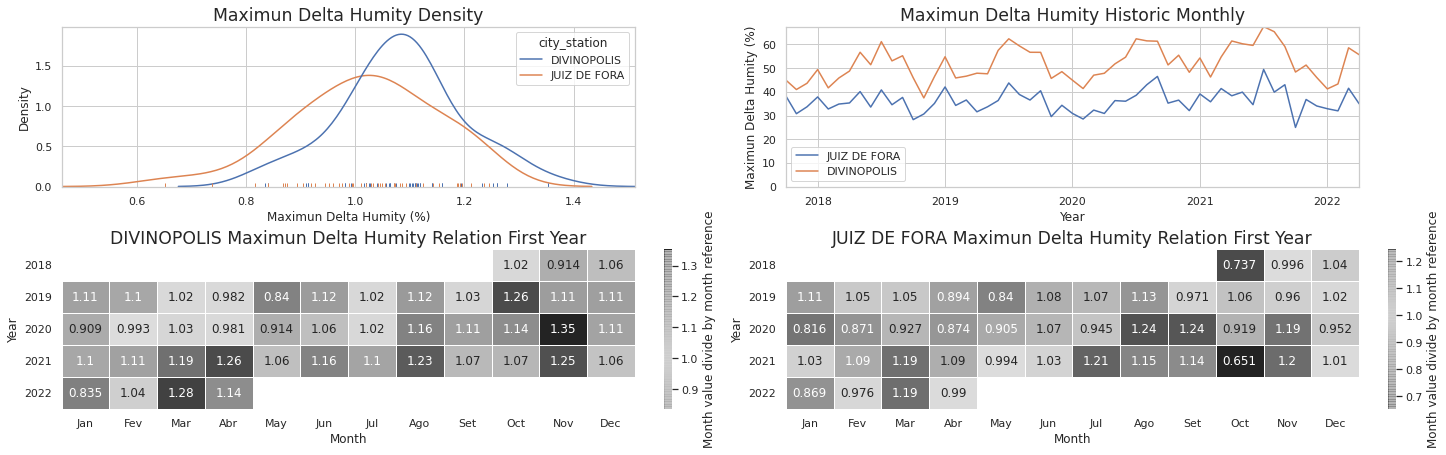

In [15]:
i = 0

for var in weather_cities_compare['weather_var'].unique():
    i += 1
    
    display(Markdown('#### 3.2.' + str(i) + ". " + cols_name[var]))
    f, ax = plt.subplots(2, 2,
                         figsize=(20, 10 * 0.618),
                         gridspec_kw=dict(width_ratios=[3,3]),
                         constrained_layout=True)

    g1 = weather_heat_map(city=0, weather_var=var)
    
    ax[0,0].margins(0,0)
    ax[0,1].margins(0,0)

    g2 = weather_heat_map(city=1, weather_var=var)

    g3 = weather_kde(weather_var=var)

    g4 = weather_month(weather_var=var)
    
    plt.show()